In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx


## Imports

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import RocCurveDisplay
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

!pip install optuna catboost joblib
import joblib
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")

!pip uninstall -y shap 
!pip install numba shap -q
import shap

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score

Found existing installation: shap 0.49.1
Uninstalling shap-0.49.1:
  Successfully uninstalled shap-0.49.1


## Data Loading

In [4]:
df = pd.read_excel("/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx")

print("Shape of dataset:", df.shape)
print("\nColumns:", df.columns.tolist())

Shape of dataset: (7043, 33)

Columns: ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason']


In [5]:
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")

## Drop Unnecessary Columns

In [6]:
drop_cols = ["CustomerID", "Count", "Lat Long", "Churn Label",
             "Churn Reason", "Churn Score", "CLTV"]

df = df.drop(columns=drop_cols, errors="ignore")

## Define Features & Targets

In [7]:
y = df["Churn Value"]
X = df.drop(columns=["Churn Value"], errors="ignore")

print("\nTarget distribution:\n", y.value_counts(normalize=True))


Target distribution:
 Churn Value
0    0.73463
1    0.26537
Name: proportion, dtype: float64


## Train-Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## Preprocessing

In [9]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

## Define Models

In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    }

results = {}

## Train & Evaluate Models

In [11]:
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Weighted F1": f1_score(y_test, y_pred, average='weighted'),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "PR AUC": average_precision_score(y_test, y_proba),
        "Model": pipe
    }

## Results & Summary

In [12]:
results_df = pd.DataFrame(results).T.sort_values(by="ROC AUC", ascending=False)
print(results_df)


                     Accuracy Precision    Recall  F1 Score Weighted F1  \
CatBoost             0.803124  0.655246  0.545455  0.595331    0.797016   
Gradient Boosting     0.80265  0.663636  0.520499  0.583417    0.794425   
Random Forest        0.795551  0.651765  0.493761  0.561866    0.785742   
Logistic Regression  0.750592  0.520142  0.782531  0.624911      0.7632   
AdaBoost             0.792712  0.619417  0.568627  0.592937    0.789794   
XGBoost              0.778041  0.589844  0.538324  0.562908    0.774697   
Decision Tree        0.762423  0.555347  0.527629  0.541133    0.760445   

                      ROC AUC    PR AUC  \
CatBoost             0.853402   0.66254   
Gradient Boosting    0.850947  0.665405   
Random Forest         0.84085  0.635316   
Logistic Regression  0.840384   0.63176   
AdaBoost             0.839637  0.602281   
XGBoost               0.82335  0.606003   
Decision Tree        0.687462  0.418431   

                                                      

## Confusion Matrices

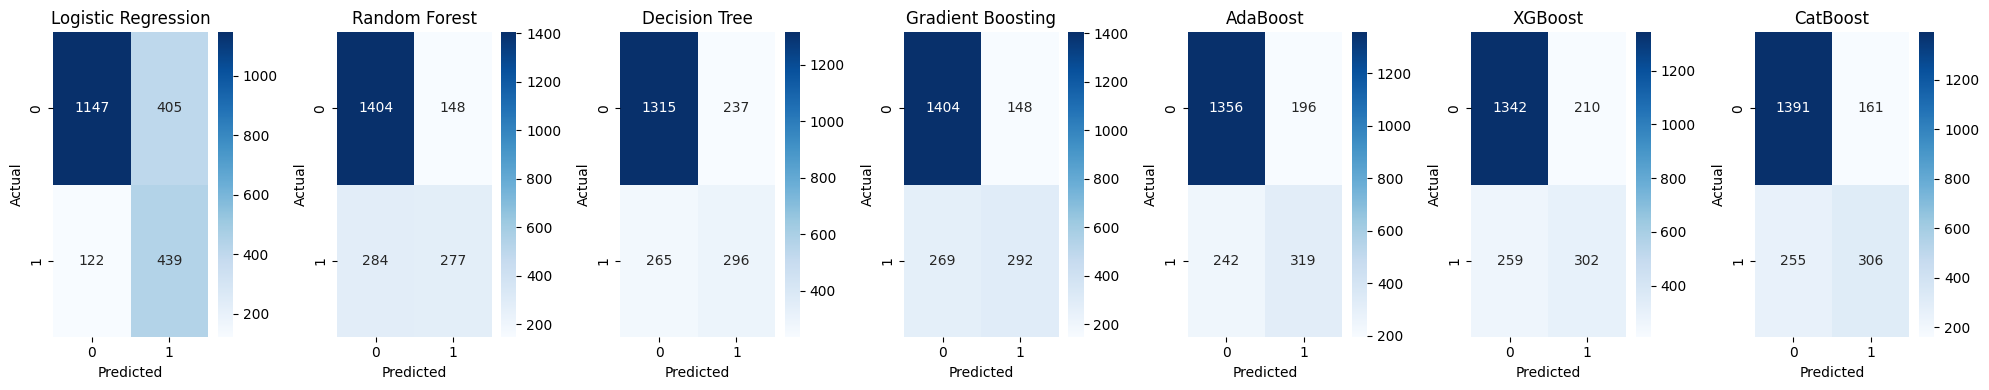

In [13]:
fig, axes = plt.subplots(1, len(models), figsize=(20, 4))
for ax, (name, res) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, res["Model"].predict(X_test))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

## ROC Curves

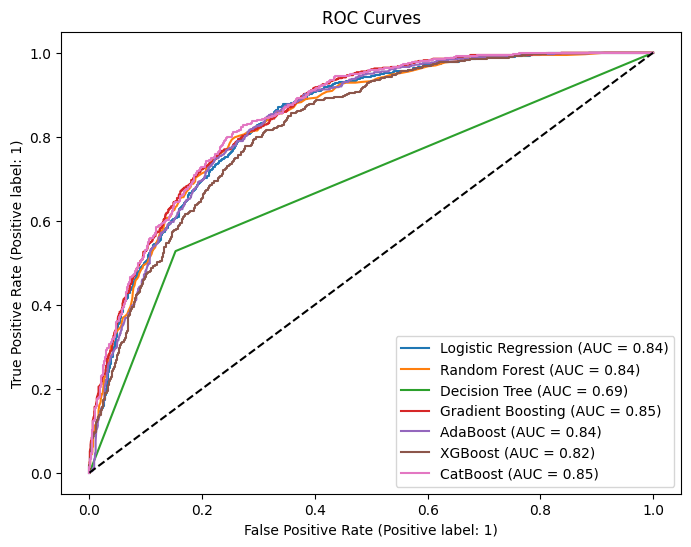

In [14]:
plt.figure(figsize=(8, 6))
for name, res in results.items():
    RocCurveDisplay.from_estimator(res["Model"], X_test, y_test, ax=plt.gca(), name=name)
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curves")
plt.show()

## Best Model

In [15]:
best_model_name = results_df.index[0]
best_model = results[best_model_name]["Model"]

print(f"\nBest model: {best_model_name}")


Best model: CatBoost


## Clustering


In [16]:
def profile_clusters(df, cluster_col, show_cols=None):
    """
    Quick profiling: numeric means + churn rate and count per cluster.
    - df: original dataframe (with original columns)
    - cluster_col: name of cluster label column on df
    - show_cols: list of numeric columns to summarize (defaults to numeric cols)
    """
    if show_cols is None:
        show_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        show_cols = [c for c in show_cols if c != cluster_col]
    profile = df.groupby(cluster_col)[show_cols].mean().round(3)
    profile['count'] = df.groupby(cluster_col).size()
    if 'Churn' in df.columns:
        # assuming Churn is binary (1/0)
        profile['churn_rate'] = df.groupby(cluster_col)['Churn'].apply(
            lambda x: np.mean(x.map({'Yes':1,'No':0}) if x.dtype == object else x.astype(float))
        ).round(3)
    return profile.sort_index()

In [17]:
# 1) Basic column cleanup 
_clust_df = df.copy()
for col in ['customerID', 'CustomerID', 'id', 'ID']:
    if col in _clust_df.columns:
        _clust_df = _clust_df.drop(columns=[col])

# 2) Convert TotalCharges to numeric if needed 
if 'TotalCharges' in _clust_df.columns:
    _clust_df['TotalCharges'] = pd.to_numeric(_clust_df['TotalCharges'], errors='coerce')
    _clust_df['TotalCharges'] = _clust_df['TotalCharges'].fillna(0)

# 3) Turn common categorical columns into dummies 
cat_cols = _clust_df.select_dtypes(include=['object', 'category']).columns.tolist()
# keep 'Churn' as-is if present (we'll keep it for profiling)
cat_cols = [c for c in cat_cols if c != 'Churn']
# one-hot encode
_clust_df_enc = pd.get_dummies(_clust_df, columns=cat_cols, drop_first=True)

# 4) Feature scaling
features_for_clustering = [c for c in _clust_df_enc.columns if c != 'Churn']  # exclude label
scaler = StandardScaler()
X_scaled = scaler.fit_transform(_clust_df_enc[features_for_clustering])

Numeric cols: ['Zip Code', 'Latitude', 'Longitude', 'Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Value']
Categorical cols: ['Country', 'State', 'City', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']
Preprocessing + PCA produced shape: (7043, 10)
Explained variance (first 5 cum): [0.24457665 0.45039985 0.59627805 0.647869   0.68134142]
k=2, silhouette=0.2216
k=3, silhouette=0.2683
k=4, silhouette=0.2574
k=5, silhouette=0.2566
k=6, silhouette=0.2668
Best k by silhouette: 3


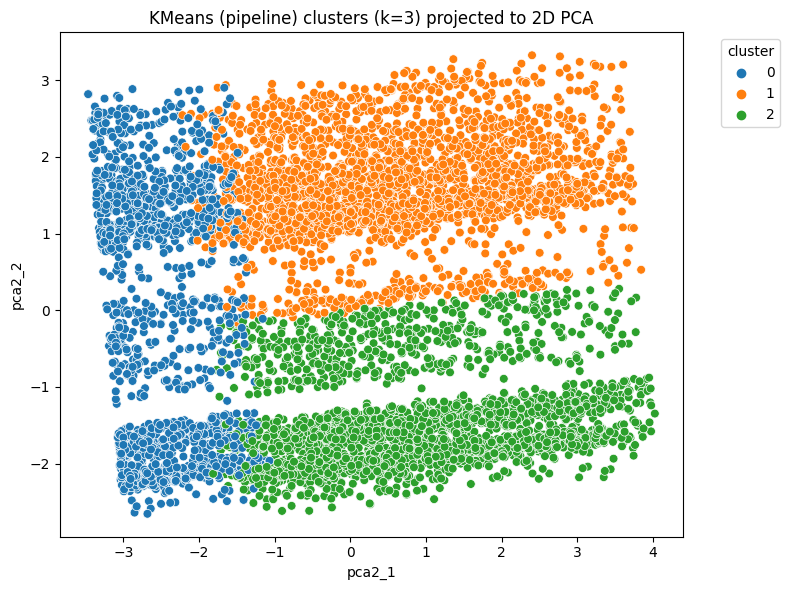

,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,count
cluster_kmeans_pipeline,,,,,,,,
0,93560.247,36.387,-119.934,30.445,21.139,663.283,0.074,1533
1,95166.028,38.503,-121.695,33.255,77.093,2757.642,0.320,2701
2,91920.220,34.091,-117.902,32.572,76.712,2708.646,0.317,2809


Adjust heuristic mapping: ensure 'MonthlyCharges' and 'tenure' are in the profile table.


In [19]:
from sklearn.cluster import KMeans

# Pipeline-based clustering with dense PCA 
if '_clust_df_enc' not in globals():
    _clust_df_enc = _clust_df.copy()

# 1) choose features for clustering
# Keeping churn separate, pipeline will handle numeric & categorical automatically.
features_for_clustering = [c for c in _clust_df.columns if c != 'Churn' and c not in ['customerID','CustomerID','id','ID']]

# Split features by dtype 
numeric_cols = _clust_df[features_for_clustering].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in features_for_clustering if c not in numeric_cols]

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# 2) build ColumnTransformer for preprocessing (impute + scale + one-hot)

# Make OneHotEncoder dense so PCA can consume the output (avoid sparse matrices).
# Use sparse_output=False for recent sklearn; fall back to sparse=False for older versions.
try:
    ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  
)

# 3) Preprocessing pipeline with PCA 
# Heuristic for components; will be capped automatically by PCA based on data shape
pca_n_components = min(10, max(2, len(features_for_clustering)//2))

preproc_with_pca = Pipeline(steps=[
    ('preproc', preprocessor),
    ('pca', PCA(n_components=pca_n_components, random_state=42))
])

# Fit-transform once (ensures identical preprocessing across k trials)
X_prep = preproc_with_pca.fit_transform(_clust_df[features_for_clustering])

print("Preprocessing + PCA produced shape:", X_prep.shape)
print("Explained variance (first 5 cum):",
      preproc_with_pca.named_steps['pca'].explained_variance_ratio_.cumsum()[:5])

# 4) K selection loop using preprocessed features
sil_scores = {}
k_range = range(2, 7)  
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_prep)
    sil = silhouette_score(X_prep, labels)
    sil_scores[k] = sil
    print(f"k={k}, silhouette={sil:.4f}")

best_k = max(sil_scores, key=sil_scores.get)
print("Best k by silhouette:", best_k)

# 5) Final pipeline: preprocessor + PCA + KMeans 
final_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('pca', PCA(n_components=pca_n_components, random_state=42)),
    ('kmeans', KMeans(n_clusters=best_k, random_state=42, n_init=20))
])

# Fit final pipeline on raw feature dataframe
final_pipeline.fit(_clust_df[features_for_clustering])

# Extract cluster labels (predict does full transform -> PCA -> kmeans)
_clust_df_enc['cluster_kmeans_pipeline'] = final_pipeline.predict(_clust_df[features_for_clustering])

# 6) 2D PCA for visualization 
viz_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('pca2', PCA(n_components=2, random_state=42))
])
X_viz = viz_pipeline.fit_transform(_clust_df[features_for_clustering])
_clust_df_enc['pca2_1'] = X_viz[:, 0]
_clust_df_enc['pca2_2'] = X_viz[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=_clust_df_enc,
    x='pca2_1', y='pca2_2',
    hue='cluster_kmeans_pipeline',
    palette='tab10', s=40
)
plt.title(f'KMeans (pipeline) clusters (k={best_k}) projected to 2D PCA')
plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 7) Profile clusters (expects you already defined profile_clusters(df, label_col))
df_with_labels = pd.concat(
    [_clust_df.reset_index(drop=True),
     _clust_df_enc[['cluster_kmeans_pipeline']].reset_index(drop=True)],
    axis=1
)
profile_km_pipe = profile_clusters(df_with_labels, 'cluster_kmeans_pipeline')
display(profile_km_pipe)

# 8) Optional: map clusters -> retention strategies (expects map_strategy(profile_table))
if {'MonthlyCharges', 'tenure'}.issubset(profile_km_pipe.columns):
    strat_map_km = map_strategy(profile_km_pipe)
    _clust_df_enc['retention_strategy_km_pipeline'] = _clust_df_enc['cluster_kmeans_pipeline'].map(strat_map_km)
    print("Assigned retention_strategy_km_pipeline to rows.")
else:
    print("Adjust heuristic mapping: ensure 'MonthlyCharges' and 'tenure' are in the profile table.")


Preprocessed feature matrix shape: (7043, 1162)
PCA (for hierarchical) shape: (7043, 10)
Explained variance (cum first 5): [0.24457665 0.45039985 0.59627805 0.647869   0.68134142]


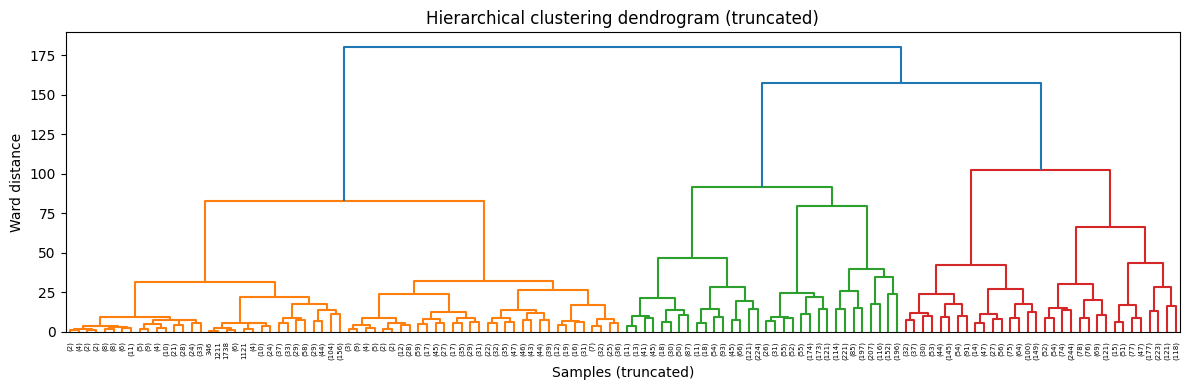

hier k=2, silhouette=0.2596
hier k=3, silhouette=0.2609
hier k=4, silhouette=0.2337
hier k=5, silhouette=0.2344
hier k=6, silhouette=0.2394
Best hierarchical k by silhouette: 3


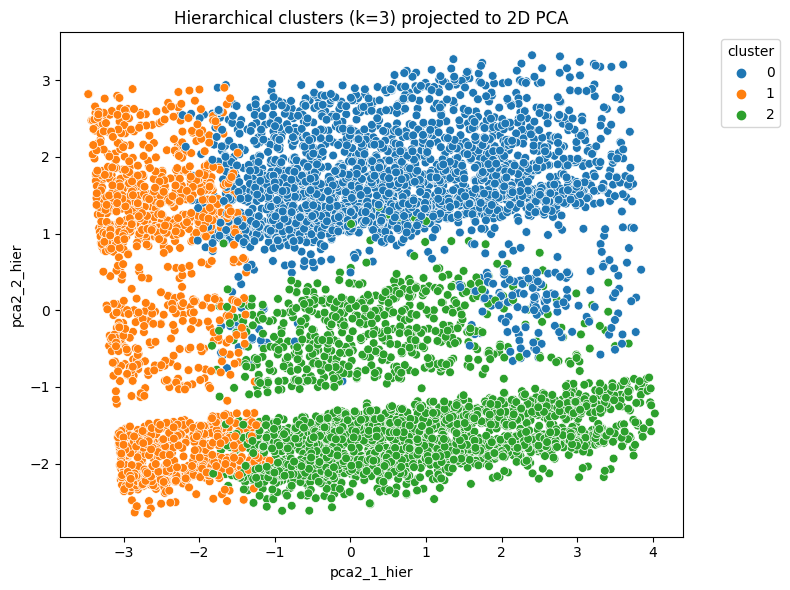

,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,count
cluster_hier_pipeline,,,,,,,,
0,95196.248,38.511,-121.711,34.243,77.660,2884.902,0.317,2615
1,93560.701,36.389,-119.933,30.547,21.079,665.220,0.074,1526
2,91992.894,34.218,-118.005,31.644,76.109,2589.439,0.319,2902


Adjust heuristic mapping: ensure MonthlyCharges and tenure are in profile table.
Cluster counts:
 cluster_hier_pipeline
0    2615
1    1526
2    2902
Name: count, dtype: int64


In [20]:
# Hierarchical clustering block 
# 1) Preprocess data 

_preproc_only = Pipeline([('preproc', preprocessor)])
X_preproc = _preproc_only.fit_transform(_clust_df[features_for_clustering])
print("Preprocessed feature matrix shape:", getattr(X_preproc, "shape", None))

# 2) Optional sTep: reduce dims for linkage & silhouette speed 
# Use PCA to reduce to, e.g., 10 dims
from sklearn.decomposition import PCA
pca_for_hier = PCA(n_components=min(10, X_preproc.shape[1]), random_state=42)
X_reduced = pca_for_hier.fit_transform(X_preproc)
print("PCA (for hierarchical) shape:", X_reduced.shape)
print("Explained variance (cum first 5):", pca_for_hier.explained_variance_ratio_.cumsum()[:5])

# 3) Truncated Dendrogram for visual guidance
Z = linkage(X_reduced, method='ward')   # 'ward' works with euclidean distances
plt.figure(figsize=(12,4))
dendrogram(Z, truncate_mode='level', p=6, show_leaf_counts=True, leaf_rotation=90.)
plt.title('Hierarchical clustering dendrogram (truncated)')
plt.xlabel('Samples (truncated)')
plt.ylabel('Ward distance')
plt.tight_layout()
plt.show()

# 4) Optional STep: silhouette-based selection for n_clusters (2..6)
from sklearn.metrics import silhouette_score
sil_scores_hier = {}
k_range = range(2, 7)
for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_reduced)
    sil = silhouette_score(X_reduced, labels)
    sil_scores_hier[k] = sil
    print(f"hier k={k}, silhouette={sil:.4f}")

best_k_hier = max(sil_scores_hier, key=sil_scores_hier.get)
print("Best hierarchical k by silhouette:", best_k_hier)

# 5) Fit final hierarchical clustering and attach labels
agg_final = AgglomerativeClustering(n_clusters=best_k_hier, linkage='ward')
_clust_df_enc['cluster_hier_pipeline'] = agg_final.fit_predict(X_reduced)

# 6) Visualize clusters in 2D (using a fresh 2-component PCA for visualization)
pca2_viz = PCA(n_components=2, random_state=42)
X_viz_hier = pca2_viz.fit_transform(X_preproc)   # transform original preproc (not the PCA-reduced used above)
_clust_df_enc['pca2_1_hier'] = X_viz_hier[:,0]
_clust_df_enc['pca2_2_hier'] = X_viz_hier[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=_clust_df_enc, x='pca2_1_hier', y='pca2_2_hier', hue='cluster_hier_pipeline', palette='tab10', s=40)
plt.title(f'Hierarchical clusters (k={best_k_hier}) projected to 2D PCA')
plt.legend(title='cluster', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# 7) Profile hierarchical clusters 
df_with_hier_labels = pd.concat([_clust_df.reset_index(drop=True),
                                 _clust_df_enc[['cluster_hier_pipeline']].reset_index(drop=True)], axis=1)
profile_hier_pipe = profile_clusters(df_with_hier_labels, 'cluster_hier_pipeline')
display(profile_hier_pipe)

# 8) Map clusters -> retention strategies 
if 'MonthlyCharges' in profile_hier_pipe.columns and 'tenure' in profile_hier_pipe.columns:
    strat_map_hier = map_strategy(profile_hier_pipe)
    _clust_df_enc['retention_strategy_hier'] = _clust_df_enc['cluster_hier_pipeline'].map(strat_map_hier)
    print("Assigned retention_strategy_hier to rows.")
else:
    print("Adjust heuristic mapping: ensure MonthlyCharges and tenure are in profile table.")

# 9) Example: inspect cluster sizes & churn by cluster
print("Cluster counts:\n", _clust_df_enc['cluster_hier_pipeline'].value_counts().sort_index())
if 'Churn' in _clust_df.columns:
    # Merge churn into _clust_df_enc if not already present in same DF
    merged = pd.concat([_clust_df.reset_index(drop=True), _clust_df_enc[['cluster_hier_pipeline']].reset_index(drop=True)], axis=1)
    churn_by_cluster = merged.groupby('cluster_hier_pipeline')['Churn'].apply(lambda s: np.mean(s.map({'Yes':1,'No':0}) if s.dtype==object else s.astype(float))).round(3)
    print("Churn rate per hierarchical cluster:\n", churn_by_cluster)


## Optuna Hyperparameter Tuning

In [21]:
# Optuna tuning + baseline comparison for CatBoost & HistGradientBoosting
RND = 42
n_trials = 20            # set lower (~ 20) for quick execution
n_jobs_cv = 4            # CV parallelism for sklearn model only
scoring = 'roc_auc'
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

# 1) Build X, y from data_df 
data_df = pd.read_excel('/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx')

# target
if data_df['Churn Value'].dtype == object:
    y = data_df['Churn Value'].map({'Yes':1, 'No':0}).astype(int).values
else:
    y = data_df['Churn Value'].astype(int).values

# features: numeric cols & top-5 categories one-hot 
num_cols = data_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ['Churn', 'Churn Value']]
cat_cols = [c for c in data_df.select_dtypes(include=['object','category']).columns.tolist() if c not in ['Churn', 'Churn Value']]

# numeric matrix with median imputation
X_num = data_df[num_cols].fillna(data_df[num_cols].median()).values if num_cols else np.empty((len(data_df),0))

# categorical top-k one-hot
top_k = 5
X_cat_parts = []
cat_feature_names = []
for c in cat_cols:
    top_vals = data_df[c].fillna('Missing').value_counts().nlargest(top_k).index.tolist()
    for val in top_vals:
        arr = (data_df[c].fillna('Missing') == val).astype(int).values
        X_cat_parts.append(arr)
        cat_feature_names.append(f"{c}__is__{val}")

if X_cat_parts:
    X_cat = np.vstack(X_cat_parts).T
    X = np.hstack([X_num, X_cat])
    feature_names = (num_cols if num_cols else []) + cat_feature_names
else:
    X = X_num
    feature_names = num_cols

X = np.asarray(X)
y = np.asarray(y)
print("Constructed X shape:", X.shape, "y shape:", y.shape)

# 2) Baseline models
def evaluate_model_cv(model, X, y, cv, scoring):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=1)  # n_jobs=1 for CatBoost
    return float(np.mean(scores)), scores

# try to load saved baseline models if available; otherwise train default baseline models
baseline_cat_path = "catboost_baseline.joblib"
baseline_hist_path = "histgb_baseline.joblib"

# Baseline CatBoost (default)
print("\nComputing baseline models (default hyperparameters) and CV AUC...")
cat_baseline = CatBoostClassifier(random_seed=RND, verbose=0)
hist_baseline = HistGradientBoostingClassifier(random_state=RND)

cat_base_mean, cat_base_scores = evaluate_model_cv(cat_baseline, X, y, cv, scoring)
hist_base_mean, hist_base_scores = evaluate_model_cv(hist_baseline, X, y, cv, scoring)

# fit baseline models on full data (so we can compare predictions later if needed) and save
cat_baseline.fit(X, y)
hist_baseline.fit(X, y)
joblib.dump(cat_baseline, baseline_cat_path)
joblib.dump(hist_baseline, baseline_hist_path)

print(f"Baseline CatBoost CV AUC: {cat_base_mean:.4f} (folds: {np.round(cat_base_scores,4)})")
print(f"Baseline HistGB CV AUC: {hist_base_mean:.4f} (folds: {np.round(hist_base_scores,4)})")

# 3) Optuna objectives (simple CV-based objectives)
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_seed': RND,
        'verbose': False,
        'task_type': 'GPU',
        'loss_function': 'Logloss',
        'eval_metric': 'AUC'
    }
    model = CatBoostClassifier(**params)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=1)  # CatBoost multithreads itself
    return float(np.mean(scores))

def objective_histgb(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'max_iter': trial.suggest_int('max_iter', 100, 2000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 15, 255),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-6, 10.0),
        'max_bins': trial.suggest_int('max_bins', 64, 255),
        'random_state': RND
    }
    model = HistGradientBoostingClassifier(**params)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs_cv)
    return float(np.mean(scores))

# 4) Run Optuna studies 
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

print(f"\nRunning Optuna tuning: n_trials={n_trials} (CatBoost)...")
study_cat = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RND))
study_cat.optimize(objective_cat, n_trials=n_trials)
print("CatBoost best CV AUC (optuna):", study_cat.best_value)
print("CatBoost best params:", study_cat.best_params)

print(f"\nRunning Optuna tuning: n_trials={n_trials} (HistGradientBoosting)...")
study_hist = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RND))
study_hist.optimize(objective_histgb, n_trials=n_trials)
print("HistGB best CV AUC (optuna):", study_hist.best_value)
print("HistGB best params:", study_hist.best_params)

# 5) Fit tuned models on full dataset and save 
print("\nFitting tuned models on full dataset...")
cat_best_params = study_cat.best_params.copy()
cat_best_params.setdefault('random_seed', RND)
cat_best_params.setdefault('verbose', 0)
cat_best_params.setdefault('loss_function', 'Logloss')
cat_best_params.setdefault('eval_metric', 'AUC')
cat_tuned = CatBoostClassifier(**cat_best_params)
cat_tuned.fit(X, y)

hist_best_params = study_hist.best_params.copy()
hist_best_params.setdefault('random_state', RND)
hist_tuned = HistGradientBoostingClassifier(**hist_best_params)
hist_tuned.fit(X, y)

joblib.dump(cat_tuned, "catboost_optuna_best.joblib")
joblib.dump(hist_tuned, "histgb_optuna_best.joblib")
print("Saved tuned models: catboost_optuna_best.joblib, histgb_optuna_best.joblib")

# 6) Evaluate tuned models (CV) and compare to baseline 
cat_tuned_mean, cat_tuned_scores = evaluate_model_cv(cat_tuned, X, y, cv, scoring)
hist_tuned_mean, hist_tuned_scores = evaluate_model_cv(hist_tuned, X, y, cv, scoring)

print("\n--- Comparison (CV ROC AUC) ---")
print(f"CatBoost: baseline = {cat_base_mean:.4f}, tuned = {cat_tuned_mean:.4f}, improvement = {cat_tuned_mean - cat_base_mean:+.4f}")
print(f"  baseline folds: {np.round(cat_base_scores,4)}")
print(f"  tuned    folds: {np.round(cat_tuned_scores,4)}")

print(f"\nHistGradientBoosting: baseline = {hist_base_mean:.4f}, tuned = {hist_tuned_mean:.4f}, improvement = {hist_tuned_mean - hist_base_mean:+.4f}")
print(f"  baseline folds: {np.round(hist_base_scores,4)}")
print(f"  tuned    folds: {np.round(hist_tuned_scores,4)}")

# 7) (Optional Step) If we plan to use a holdout/test set named data_test_df, evaluate on it too
if 'data_test_df' in globals():
    print("\nEvaluating on data_test_df holdout set (if present)...")
    # build X_test,y_test same simple way as above
    test_df = data_test_df.copy()
    if 'Churn Value' not in test_df.columns:
        print("data_test_df found but no 'Churn Value' column — skipping test evaluation.")
    else:
        if test_df['Churn Value'].dtype == object:
            y_test = test_df['Churn Value'].map({'Yes':1,'No':0}).astype(int).values
        else:
            y_test = test_df['Churn Value'].astype(int).values
        # build numeric + top-k dummies using the SAME feature_names from training (this is simplistic)
        X_test_num = test_df[num_cols].fillna(data_df[num_cols].median()).values if num_cols else np.empty((len(test_df),0))
        X_test_cat_parts = []
        for i, name in enumerate(cat_feature_names):
            colname, __, val = name.partition('__is__')
            X_test_cat_parts.append((test_df[colname].fillna('Missing') == val).astype(int).values)
        if X_test_cat_parts:
            X_test_cat = np.vstack(X_test_cat_parts).T
            X_test = np.hstack([X_test_num, X_test_cat])
        else:
            X_test = X_test_num
        X_test = np.asarray(X_test)
        from sklearn.metrics import roc_auc_score
        y_pred_cat = cat_tuned.predict_proba(X_test)[:,1]
        y_pred_hist = hist_tuned.predict_proba(X_test)[:,1]
        print("CatBoost test AUC:", roc_auc_score(y_test, y_pred_cat).round(4))
        print("HistGB  test AUC:", roc_auc_score(y_test, y_pred_hist).round(4))

# Done
print("\nTuning + comparison complete. Use the saved models to score new customers or for further analysis.")

Constructed X shape: (7043, 80) y shape: (7043,)

Computing baseline models (default hyperparameters) and CV AUC...
Baseline CatBoost CV AUC: 1.0000 (folds: [1. 1. 1. 1. 1.])
Baseline HistGB CV AUC: 1.0000 (folds: [1. 1. 1. 1. 1.])

Running Optuna tuning: n_trials=20 (CatBoost)...


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric perio

CatBoost best CV AUC (optuna): 1.0
CatBoost best params: {'iterations': 874, 'depth': 10, 'learning_rate': 0.06504856968981275, 'l2_leaf_reg': 0.24810409748678125, 'border_count': 66, 'bagging_temperature': 0.15599452033620265}

Running Optuna tuning: n_trials=20 (HistGradientBoosting)...
HistGB best CV AUC (optuna): 1.0
HistGB best params: {'learning_rate': 0.008468008575248327, 'max_iter': 1907, 'max_leaf_nodes': 191, 'min_samples_leaf': 60, 'l2_regularization': 1.2363188277052228e-05, 'max_bins': 93}

Fitting tuned models on full dataset...
Saved tuned models: catboost_optuna_best.joblib, histgb_optuna_best.joblib

--- Comparison (CV ROC AUC) ---
CatBoost: baseline = 1.0000, tuned = 1.0000, improvement = +0.0000
  baseline folds: [1. 1. 1. 1. 1.]
  tuned    folds: [1. 1. 1. 1. 1.]

HistGradientBoosting: baseline = 1.0000, tuned = 1.0000, improvement = +0.0000
  baseline folds: [1. 1. 1. 1. 1.]
  tuned    folds: [1. 1. 1. 1. 1.]

Tuning + comparison complete. Use the saved models to 

## Business Evaluation

Profit-Aware Campaign Summary
num_targeted: 1277
total_expected_retained: 67785.85189507753
total_campaign_cost: 19155.0
roi: 3.5388071989077283
avg_ev_per_target: 53.08210798361592
threshold_metric: 0.005225845367558435
ranking: ev
campaign_cost: 15.0
success_prob: 0.3
budget_k: None

ROI vs K (head)


,K,total_expected_retained,total_campaign_cost,ROI
0,1,208.922268,15.0,13.928151
1,2,413.914893,30.0,13.797163
2,3,616.503886,45.0,13.700086
3,4,804.646061,60.0,13.410768
4,5,992.500355,75.0,13.233338
5,6,1178.790027,90.0,13.097667
6,7,1360.927541,105.0,12.961215
7,8,1532.994260,120.0,12.774952
8,9,1701.640577,135.0,12.604745
9,10,1868.081875,150.0,12.453879


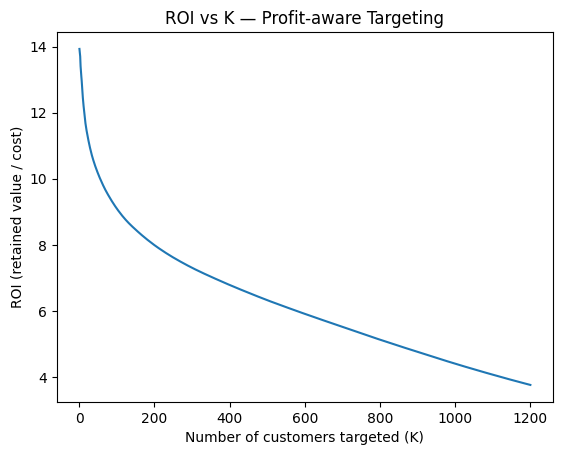

In [22]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Column utilities

def _normalize_cols(cols):
    return {c: ''.join(str(c).strip().lower().replace('\n', ' ').split()).replace('_', '')
            for c in cols}

def _find_col(df: "pd.DataFrame", candidates: list[str]) -> str | None:
    norm = _normalize_cols(df.columns)
    inv = {v: k for k, v in norm.items()}
    for cand in candidates:
        key = ''.join(cand.strip().lower().split()).replace('_', '')
        if key in inv:
            return inv[key]
    return None

def _as_float(series: "pd.Series") -> "pd.Series":
    return pd.to_numeric(series, errors='coerce')

# CLV lost estimator tuned for dataset
def infer_clv_lost_excel_safe(
    X: "pd.DataFrame",
    fallback_horizon_months: int = 6,
    use_contract_remaining: bool = True
) -> "pd.Series":
    """
    CLV_lost ≈ MonthlyCharges * remaining_months
    remaining_months is inferred from Contract & tenure when available.
    """
    col_monthly = _find_col(X, ['monthlycharges','monthlycharge','monthly_charges','monthly charges','monthly'])
    col_total   = _find_col(X, ['totalcharges','totalcharge','total_charges','total charges','total'])
    col_tenure  = _find_col(X, ['tenure'])
    col_contract= _find_col(X, ['contract'])

    tenure = _as_float(X[col_tenure]) if col_tenure else pd.Series(0, index=X.index, dtype=float)
    tenure = tenure.fillna(0)

    if col_monthly:
        monthly = _as_float(X[col_monthly]).fillna(0)
    else:
        if col_total:
            total = _as_float(X[col_total]).fillna(0)
            monthly = total / tenure.clip(lower=1)
        else:
            monthly = pd.Series(0, index=X.index, dtype=float)

    if use_contract_remaining and col_contract:
        contract_raw = X[col_contract].astype(str).str.lower()
        rem_1yr = (12 - tenure.clip(upper=12)).clip(lower=0)
        rem_2yr = (24 - tenure.clip(upper=24)).clip(lower=0)

        horizon = pd.Series(float(fallback_horizon_months), index=X.index)
        m2m_mask = contract_raw.str.contains('month', na=False)
        one_mask = contract_raw.str.contains('one',   na=False)
        two_mask = contract_raw.str.contains('two',   na=False)
        horizon[m2m_mask] = float(fallback_horizon_months)
        horizon[one_mask] = rem_1yr[one_mask]
        horizon[two_mask] = rem_2yr[two_mask]
    else:
        horizon = pd.Series(float(fallback_horizon_months), index=X.index)

    return monthly * horizon

# Profit-aware evaluation & ROI curve
def profit_aware_evaluation(
    y_true: "pd.Series | np.ndarray",
    y_prob: "pd.Series | np.ndarray",
    clv_lost: "pd.Series",
    campaign_cost: float = 20.0,
    success_prob: float = 0.30,
    budget_k: int | None = None,
    sort_by: str = "ev",       # 'ev' or 'prob'
    return_details: bool = False
) -> dict | tuple:
    """
    EV_i = p_i * (CLV_lost_i * success_prob) - campaign_cost
    """
    df = pd.DataFrame({
        'y_true': pd.Series(y_true).astype(int).values,
        'p_churn': pd.Series(y_prob).astype(float).values,
        'CLV_lost': pd.Series(clv_lost).astype(float).values,
    })
    df['EV'] = df['p_churn'] * (df['CLV_lost'] * success_prob) - campaign_cost

    if sort_by == "prob":
        df = df.sort_values('p_churn', ascending=False)
        thresh_col = 'p_churn'
    else:
        df = df.sort_values('EV', ascending=False)
        thresh_col = 'EV'

    if budget_k is not None:
        targeted = df.head(int(budget_k)).copy()
    else:
        targeted = df[df['EV'] > 0].copy()

    total_ev = targeted['EV'].sum()
    total_cost = campaign_cost * len(targeted)
    roi = (total_ev / total_cost) if total_cost > 0 else np.nan
    avg_ev = targeted['EV'].mean() if len(targeted) > 0 else 0.0
    threshold_metric = targeted[thresh_col].min() if len(targeted) > 0 else np.nan

    summary = {
        'num_targeted': int(len(targeted)),
        'total_expected_retained': float(total_ev),
        'total_campaign_cost': float(total_cost),
        'roi': float(roi),
        'avg_ev_per_target': float(avg_ev),
        'threshold_metric': float(threshold_metric) if pd.notnull(threshold_metric) else np.nan,
        'ranking': sort_by,
        'campaign_cost': float(campaign_cost),
        'success_prob': float(success_prob),
        'budget_k': int(budget_k) if budget_k is not None else None,
    }

    if return_details:
        return summary, df
    return summary

def roi_vs_k_curve(
    y_true: "pd.Series | np.ndarray",
    y_prob: "pd.Series | np.ndarray",
    clv_lost: "pd.Series",
    campaign_cost: float = 20.0,
    success_prob: float = 0.30,
    max_k: int | None = None,
    sort_by: str = "ev"
) -> "pd.DataFrame":
    df = pd.DataFrame({
        'p_churn': pd.Series(y_prob).astype(float).values,
        'CLV_lost': pd.Series(clv_lost).astype(float).values,
    })
    df['EV'] = df['p_churn'] * (df['CLV_lost'] * success_prob) - campaign_cost

    if sort_by == "prob":
        df = df.sort_values('p_churn', ascending=False)
    else:
        df = df.sort_values('EV', ascending=False)

    n = len(df) if max_k is None else min(int(max_k), len(df))
    ks = np.arange(1, n + 1, dtype=int)

    csum_ev = df['EV'].cumsum().iloc[:n]
    cost = campaign_cost * ks
    roi = np.where(cost > 0, csum_ev / cost, np.nan)

    return pd.DataFrame({
        'K': ks,
        'total_expected_retained': csum_ev.values,
        'total_campaign_cost': cost,
        'ROI': roi
    })

# Profit aware evaluation on dataset
clv_lost_series = infer_clv_lost_excel_safe(
    X_test,
    fallback_horizon_months=6,     # adjust if you assume a different fallback horizon
    use_contract_remaining=True    # uses Contract & tenure when available
)

summary = profit_aware_evaluation(
    y_true=y_test,
    y_prob=y_pred_proba,
    clv_lost=clv_lost_series,
    campaign_cost=15.0,   # per-target cost of the intervention/offer
    success_prob=0.30,    # estimated save rate
    budget_k=None,         # e.g., target top-n by EV; set None to target all EV>0
    sort_by='ev',
    return_details=False
)

roi_curve_df = roi_vs_k_curve(
    y_true=y_test,
    y_prob=y_pred_proba,
    clv_lost=clv_lost_series,
    campaign_cost=15.0,
    success_prob=0.30,
    max_k=1200,
    sort_by='ev'
)

# Output
print("Profit-Aware Campaign Summary")
for k, v in summary.items():
    print(f"{k}: {v}")

print("\nROI vs K (head)")
try:
    display(roi_curve_df.head(20))
except Exception:
    print(roi_curve_df.head(20).to_string(index=False))

plt.figure()
plt.plot(roi_curve_df['K'], roi_curve_df['ROI'])
plt.xlabel('Number of customers targeted (K)')
plt.ylabel('ROI (retained value / cost)')
plt.title('ROI vs K — Profit-aware Targeting')
plt.show()

## SHAP

SHAP Summary Plot (Key Drivers of Churn):


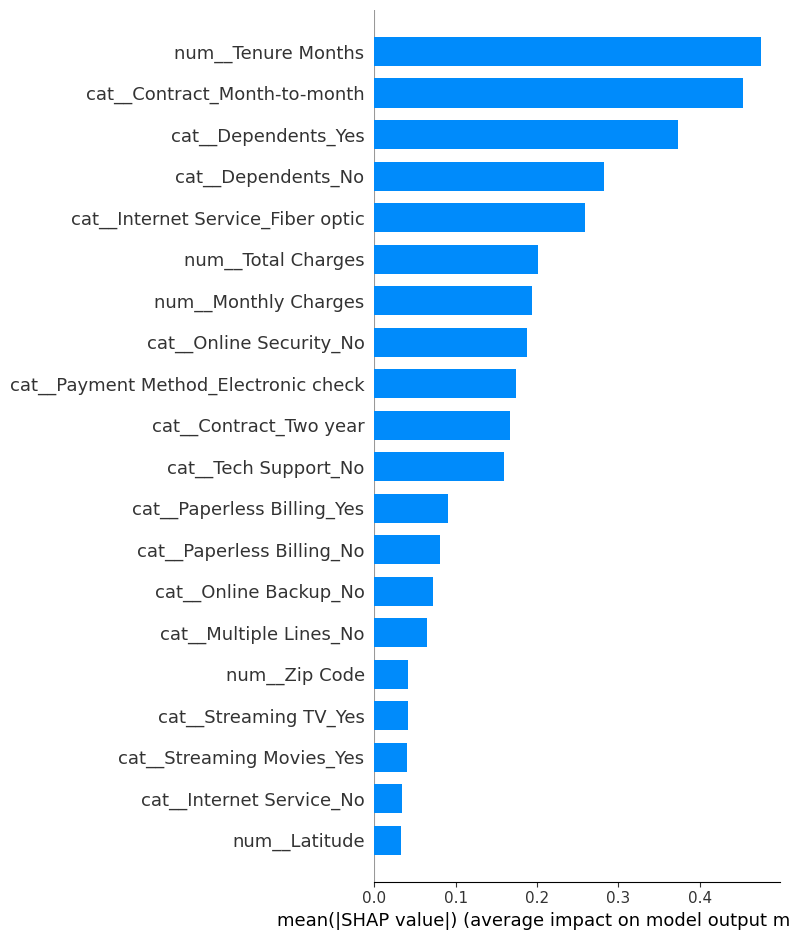

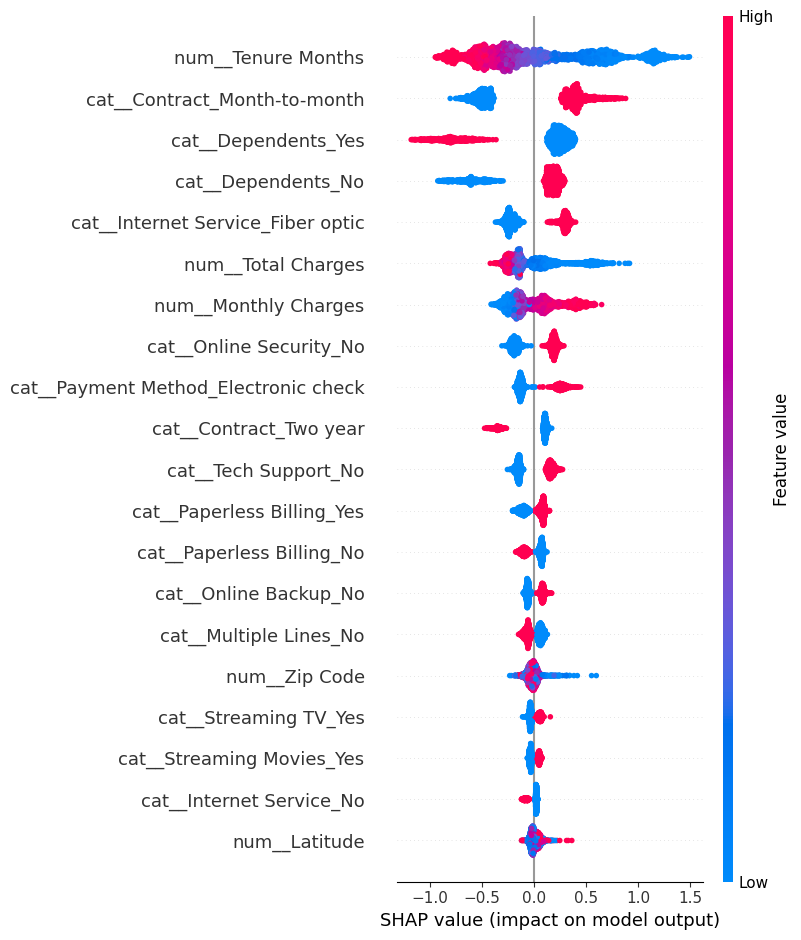

In [23]:
shap.initjs()

best_model_name = results_df.index[0]
best_model_pipeline = results[best_model_name]["Model"]

preprocessor = best_model_pipeline.named_steps['preprocessor']
model_cb = best_model_pipeline.named_steps['model']


X_test_transformed = preprocessor.transform(X_test)

try:
    feature_names = preprocessor.get_feature_names_out()
except Exception as e:
    print(f"Warning: Could not get feature names automatically ({e}). Using generic names.")
    # Fallback if get_feature_names_out is not available
    feature_names = [f"feature_{i}" for i in range(X_test_transformed.shape[1])]

# Convert the (potentially sparse) transformed data to a DataFrame
# SHAP explainers work best with DataFrames
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed_df = pd.DataFrame(X_test_transformed.toarray(), columns=feature_names)
else:
    X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)


explainer = shap.TreeExplainer(model_cb)

# Calculate SHAP values

shap_values = explainer.shap_values(X_test_transformed_df)

# Generate the summary plot to identify key drivers
print("SHAP Summary Plot (Key Drivers of Churn):")

# Bar plot (shows mean absolute impact)
shap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar", title="Key Drivers (Mean Absolute SHAP Value)")

# Dot plot (shows impact and direction for each customer)
shap.summary_plot(shap_values, X_test_transformed_df, title="Key Drivers (SHAP Value Distribution)")

Bar Plot: This plot shows the average impact (mean absolute SHAP value) of each feature on the model's prediction. The features at the top are the most important "key drivers" of churn overall.

Dot Plot (Beeswarm): This plot is more detailed. Features are ranked by importance on the left.

1. Impact: The x-axis shows the SHAP value. A positive SHAP value means the feature pushed the prediction towards churn (1). A negative value means it pushed the prediction away from churn (0).

2. Original Value: The color of the dot shows the feature's original value (High = Red, Low = Blue).

Example: If "Contract__is__Month-to-month" is high on the list, and its red dots are mostly on the positive (right) side of the plot, it means that having a month-to-month contract (high value = 1, or "Yes") is a strong driver for churning.

## Prediction Files

In [24]:
training_features = [c for c in df.columns if c not in ['Churn','Churn Value','customerID','CustomerID','id','ID']]

# pick an id column for submission
id_col = 'customerID' if 'customerID' in df.columns else ('CustomerID' if 'CustomerID' in df.columns else None)
customer_ids = df[id_col] if id_col else df.index

# predict with the pipeline (it will transform internally)
y_pred_bin = best_model.predict(df[training_features])

submission = pd.DataFrame({
    "CustomerID": customer_ids,
    "Churn_Prediction": y_pred_bin
})
submission.to_csv("churn_predictions.csv", index=False)
print("Submission file saved: churn_predictions.csv")

Submission file saved: churn_predictions.csv
